<a href="https://colab.research.google.com/github/chaordic-cp/KRTH/blob/main/KRTH_Chapter_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Chapter 2: Money Management according to Kelly Criterion: the first encounter

Kelly Criterion Simple Example:
Imagine there is a stock that yields either \$2.70 or \$0.30 for each dollar invested with probability 1/2. 

Expected wealth = (0.5)(2.7) + (0.5)*0.3 = 1.5. 

What happens in the long run?
$(2.7)^{50} * (0.3)^{50} \approx 0$
We are going to go broke!!

What happens if we hold 42% of our wealth in the stock instead of the entirety of it. We always keep 42%, so if there are ups and downs, we are going to adjust accordingly. 

$[(1-0.42) + 2.7*(0.42) * (1-0.42) + (0.3)(0.42)]^{50} = 13828.53$
even if we only win 40% of the time, we can still make a profit!
$((1-0.42) + 2.7*(0.42))^{40} * ((1-0.42) + (0.3)(0.42))^{60} = 1.94$

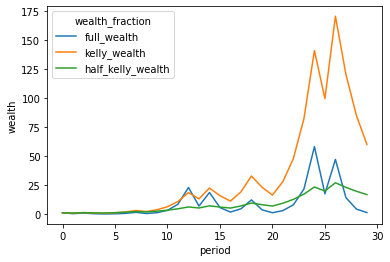

In [4]:
## plot a sample of kelly, half kelly, and full investment scenarios after 30 trades
import scipy as sp
from scipy.stats import binom
import seaborn as sns
import pandas as pd
import numpy as np

n_trades = 30
period = np.linspace(0, n_trades-1, num=n_trades)
outcomes = binom.rvs(1, 0.5, size = n_trades)
wealth = [1] * n_trades # start with a wealth value of 1 in each instance
wealth_k = [1] * n_trades # kelly wealth
wealth_hk = [1] * n_trades # half kelly wealth
# we need to write a loop that will calculate the kelly value after each outcome
for i in range(1, len(outcomes)):
  if outcomes[i] == 0:
    wealth[i] = wealth[i-1] * (1-0.7)
    wealth_k[i] = wealth_k[i-1] * 0.42 * (1-0.7) + wealth_k[i-1] * (1-0.42)
    wealth_hk[i] = wealth_hk[i-1] * 0.21 * (1-0.7) + wealth_hk[i-1] * (1-0.21)
  else:
    wealth[i] = wealth[i-1] * (1+1.7)
    wealth_k[i] = wealth_k[i-1] * 0.42 * (1+1.7) + wealth_k[i-1] * (1-0.42)
    wealth_hk[i] = wealth_hk[i-1] * 0.21 * (1+1.7) + wealth_hk[i-1] * (1-0.21)


df = pd.DataFrame(data = {'full_wealth':wealth,
                          'kelly_wealth':wealth_k,
                          'half_kelly_wealth':wealth_hk,
                          'period':period})
# we should melt this data into long form to plot in seaborn, ie make the data tidy
dfm = df.melt('period', var_name = 'wealth_fraction', value_name = 'wealth')
sns.lineplot(data=dfm, x='period', y='wealth', hue='wealth_fraction')
# sns.lineplot(data=df, x='period', y='kelly_wealth')
# sns.lineplot(data=df, x='period', y='half_kelly_wealth')

Note that the full wealth investment denegrates to nearly 0 in just 30 trades (periods). The half kelly and full kelly investment strategy perform significantly better than the full investment strategy. 

The kelly solution is simple to calculate, we just want to take the maximum of the log utility as follows:

$MAX$ $0.5ln(1+1.7u) + 0.5ln(1-0.7u)$

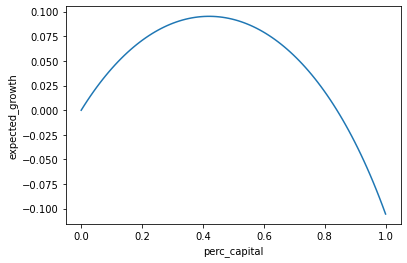

In [5]:
# now we will plot the expected growth rate vs capital fraction in stock
import numpy as np
u = np.linspace(0, 1, num = 100)
xgr = 0.5*(np.log(1+1.7*u) + np.log(1-0.7*u))

df = pd.DataFrame({'perc_capital':u, 'expected_growth':xgr})

sns.lineplot(data=df, x='perc_capital', y='expected_growth')

In [6]:
# lets do an additional exercise by solving for the kelly optimal percent of capital to invest based on the scenario we present
# and write a function in python to calculate and plot the full kelly, half kelly, and fully invested strategies, 
# similar to the above, but done in a nice python function where inputs are provided

from scipy.optimize import minimize

def log_util(u, p1, r1, r2):
  # inverse log utility so we can use the scipy minimize function
  return -1.0 *(p1*np.log(1+r1*u) + (1-p1)*np.log(1-r2*u))

def minimize_util(p1, r1, r2):
  kr = minimize(log_util, 0, args = (p1, r1, r2), method = 'BFGS')
  return kr.x[0]

def wealth(p1, r1, r2, n_trades, wealth_1, f):
  # n is the number of trades, wealth_1 is starting wealth, f is the kelly fraction to be considered
  k = minimize_util(p1, r1, r2)
  wealth, wealth_k, wealth_fk = [wealth_1] * n_trades, [wealth_1] * n_trades, [wealth_1] * n_trades
  periods = np.linspace(0, n_trades-1, num=n_trades)
  outcomes = binom.rvs(1, p1, size = n_trades)
  for i in range(1, len(outcomes)):
    if outcomes[i] == 0:
      wealth[i] = wealth[i-1] * (1-r2)
      wealth_k[i] = wealth_k[i-1] * k * (1-r2) + wealth_k[i-1] * (1-k)
      wealth_fk[i] = wealth_fk[i-1] * f*k * (1-r2) + wealth_fk[i-1] * (1-f*k)
    else:
      wealth[i] = wealth[i-1] * (1+r1)
      wealth_k[i] = wealth_k[i-1] * k * (1+r1) + wealth_k[i-1] * (1-k)
      wealth_fk[i] = wealth_fk[i-1] * f*k * (1+r1) + wealth_fk[i-1] * (1-f*k)
  df = pd.DataFrame(data = {'full_wealth':wealth,
                          'kelly_wealth':wealth_k,
                          'half_kelly_wealth':wealth_fk,
                          'periods':periods})
  return df

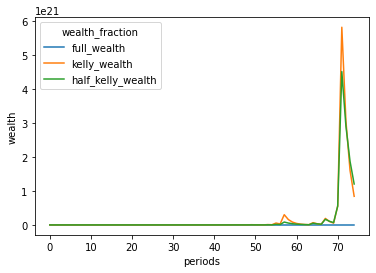

In [8]:
df = wealth(.5, .05, 1, 75, 1, .75)
dfm = df.melt('periods', var_name = 'wealth_fraction', value_name = 'wealth')
sns.lineplot(data=dfm, x='periods', y='wealth', hue='wealth_fraction')